In [1]:
from scipy.io import loadmat
from ssmlearnpy import SSMLearn
from ssmlearnpy.reduced_dynamics.advector import advect
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

mat = loadmat('dataRe135.mat')
n_traj_train = 2
t_train = [mat['aData'][i][0].flatten() for i in range(n_traj_train)]
x_full_train = [mat['aData'][i][1] for i in range(n_traj_train)]
x_reduced_train = [np.sqrt(mat['xData'][i][1]) for i in range(n_traj_train)]
x_shift = -np.matmul(mat['pcaComponents'],mat['pcaMean'].T)
ini_Time, end_Time = 400, 1400
for i_traj in range(n_traj_train):
    t_i, x_i, x_r_i = t_train[i_traj], x_full_train[i_traj], x_reduced_train[i_traj]
    idx_Ini, idx_End = int(np.sum(t_i<ini_Time)), int(np.sum(t_i<end_Time))+1
    t_train[i_traj] = t_i[idx_Ini:idx_End]
    x_full_train[i_traj] = x_i[:,idx_Ini:idx_End]-x_shift
    x_reduced_train[i_traj] = x_r_i[:,idx_Ini:idx_End]

n_traj_test = len(mat['aData'])-n_traj_train
t_test = [mat['aData'][i][0].flatten() for i in range(n_traj_train,len(mat['aData']))]
x_full_test = [mat['aData'][i][1] for i in range(n_traj_train,len(mat['aData']))]
x_reduced_test = [np.sqrt(mat['xData'][i][1]) for i in range(n_traj_train,len(mat['aData']))]
ini_Time, end_Time = 100, 1400
for i_traj in range(n_traj_test):
    t_i, x_i, x_r_i = t_test[i_traj], x_full_test[i_traj], x_reduced_test[i_traj]
    idx_Ini, idx_End = int(np.sum(t_i<ini_Time)), int(np.sum(t_i<end_Time))+1
    t_test[i_traj] = t_i[idx_Ini:idx_End]
    x_full_test[i_traj] = x_i[:,idx_Ini:idx_End]-x_shift
    x_reduced_test[i_traj] = x_r_i[:,idx_Ini:idx_End]    


In [2]:
ssm = SSMLearn(
    t = t_train, 
    x = x_full_train, 
    reduced_coordinates = x_reduced_train,
    ssm_dim=2, 
    dynamics_type = 'map'
)
ssm.get_parametrization(poly_degree=2)    
ssm.get_reduced_dynamics(poly_degree=4) 
ssm.predict()  

INFO   2022-09-28 16:56:49 ridge Transforming data
INFO   2022-09-28 16:56:49 ridge Skipping CV on ridge regression
INFO   2022-09-28 16:56:49 ridge Fitting regression model
INFO   2022-09-28 16:56:50 ridge Transforming data
INFO   2022-09-28 16:56:50 ridge Skipping CV on ridge regression
INFO   2022-09-28 16:56:50 ridge Fitting regression model


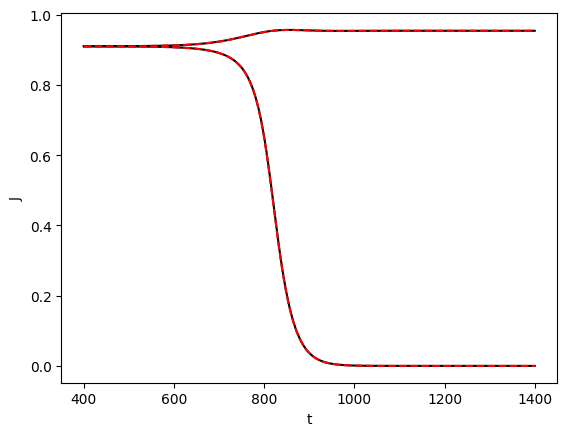

In [3]:
t_predict = ssm.reduced_dynamics_predictions['time']
x_predict = ssm.reduced_dynamics_predictions['reduced_coordinates']
e_predict = ssm.reduced_dynamics_predictions['errors']
for i_traj in range(n_traj_train):
    plt.plot(
        t_train[i_traj], 
        x_reduced_train[i_traj][0,:],
        'k'
    )

    plt.plot(
        t_predict[i_traj], 
        x_predict[i_traj][0,:],
        'r--'
    )

plt.xlabel("t")
plt.ylabel("J")

plt.show()  

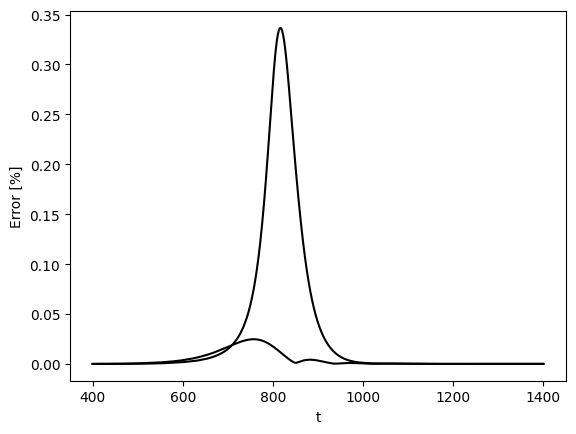

In [4]:
e_predict = ssm.reduced_dynamics_predictions['errors']
for i_traj in range(n_traj_train):
    plt.plot(
        t_predict[i_traj], 
        e_predict[i_traj]*100,
        'k'
    )

plt.xlabel("t")
plt.ylabel("Error [%]")

plt.show()  

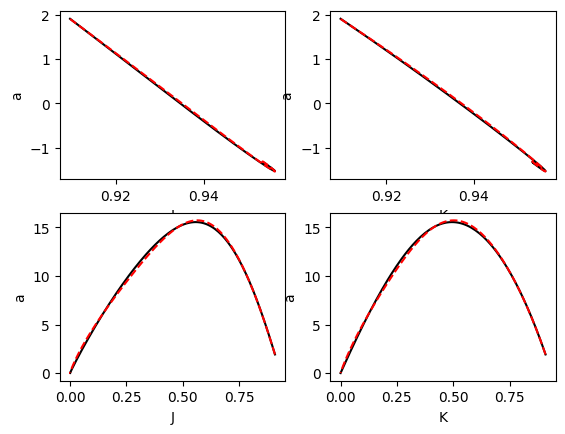

In [5]:
t_predict = ssm.predictions['time']
x_predict = ssm.predictions['observables']
e_predict = ssm.predictions['errors']

fig = plt.figure()
n_coord, idx_coord, c_plot = 2, 1, 0
x_labels = ['J', 'K']
for i_traj in range(n_traj_train):
    for i_coord in range(n_coord):
        c_plot = c_plot + 1
        ax = fig.add_subplot(n_coord, n_traj_train, c_plot)
        ax.plot(
            x_reduced_train[i_traj][i_coord,:], 
            x_full_train[i_traj][idx_coord,:],
            'k'
        )

        ax.plot(
            x_reduced_train[i_traj][i_coord,:],
            x_predict[i_traj][idx_coord,:],
            'r--'
        )

        ax.set_xlabel(x_labels[i_coord])
        ax.set_ylabel("a")

plt.show() 

In [6]:
test_predictions = ssm.predict(t = t_test, x = x_full_test, x_reduced = x_reduced_test)  

In [7]:
t_predict = test_predictions['time']
x_predict = test_predictions['reduced_coordinates']
e_predict = test_predictions['errors']
for i_traj in range(n_traj_test):
    plt.plot(
        t_train[i_traj], 
        x_reduced_train[i_traj][0,:],
        'k'
    )

    plt.plot(
        t_predict[i_traj], 
        x_predict[i_traj][0,:],
        'r--'
    )

plt.xlabel("t")
plt.ylabel("J")

plt.show()  

[array([[-4.91691415e+01, -4.90949627e+01, -4.90183115e+01, ...,
         1.04445090e-04,  1.03816390e-04,  1.02917833e-04],
       [ 5.54936180e+00,  5.63620453e+00,  5.72533282e+00, ...,
        -7.10627501e-05, -7.06349939e-05, -7.00236298e-05],
       [-5.51209914e-01, -5.56518570e-01, -5.61742971e-01, ...,
         1.11669882e-04,  1.10997689e-04,  1.10036977e-04],
       ...,
       [-8.31145299e-07, -8.46281908e-07, -8.61959437e-07, ...,
        -1.43597876e-10, -1.42733498e-10, -1.41498110e-10],
       [ 1.12253961e-06,  1.11590091e-06,  1.10900533e-06, ...,
        -4.39417136e-11, -4.36772099e-11, -4.32991744e-11],
       [-5.24446403e-07, -5.23861335e-07, -5.23253253e-07, ...,
        -7.47498619e-12, -7.42999085e-12, -7.36568277e-12]]), array([[-5.26715889e+01, -5.26822877e+01, -5.26930326e+01, ...,
        -5.34522696e+01, -5.34522696e+01, -5.34522696e+01],
       [ 5.23301717e-01,  5.03414556e-01,  4.83345136e-01, ...,
        -1.34403802e+00, -1.34403802e+00, -1.34403802

In [ ]:
for i_traj in range(n_traj_test):
    plt.plot(
        t_predict[i_traj], 
        e_predict[i_traj]*100,
        'k'
    )

plt.xlabel("t")
plt.ylabel("Error [%]")

plt.show()  